In [ ]:
!pip install tensorflow

In [ ]:
!pip install keras

In [1]:
# Import required libraries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from keras.regularizers import l2
from keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [2]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [3]:
# Import the three datasets - '\t' used for tab-delimited file, file separated value
amazon = pd.read_csv(
    'amazon_cells_labelled.txt',
    delimiter='\t',
    header=None,
    names=['reviews', 'sentiment'],
    quoting=3
)
imdb = pd.read_csv(
    'imdb_labelled.txt',
    delimiter='\t',
    header=None,
    names=['reviews', 'sentiment'],
    quoting=3
)
yelp = pd.read_csv(
    'yelp_labelled.txt',
    delimiter='\t',
    header=None,
    names=['reviews', 'sentiment'],
    quoting=3
)

In [4]:
# Add source columns
amazon['source'] = 'amazon'
imdb['source'] = 'imdb'
yelp['source'] = 'yelp'

# Combine the datasets
df = pd.concat([amazon, imdb, yelp], ignore_index=True)

# Display the total number of rows and a few sample rows
print(f'Total rows after concatenation: {len(df)}')
print(df.head())

Total rows after concatenation: 3000
                                             reviews  sentiment  source
0  So there is no way for me to plug it in here i...          0  amazon
1                        Good case, Excellent value.          1  amazon
2                             Great for the jawbone.          1  amazon
3  Tied to charger for conversations lasting more...          0  amazon
4                                  The mic is great.          1  amazon


In [5]:
# Check dataset shape - shows rows and columns
df

,reviews,sentiment,source
0,So there is no way for me to plug it in here i...,0,amazon
1,"Good case, Excellent value.",1,amazon
2,Great for the jawbone.,1,amazon
3,Tied to charger for conversations lasting more...,0,amazon
4,The mic is great.,1,amazon
...,...,...,...
2995,I think food should have flavor and texture an...,0,yelp
2996,Appetite instantly gone.,0,yelp
2997,Overall I was not impressed and would not go b...,0,yelp
2998,"The whole experience was underwhelming, and I ...",0,yelp


In [6]:
df.shape

(3000, 3)

Sentiment distribution:
 sentiment
0    0.5
1    0.5
Name: proportion, dtype: float64


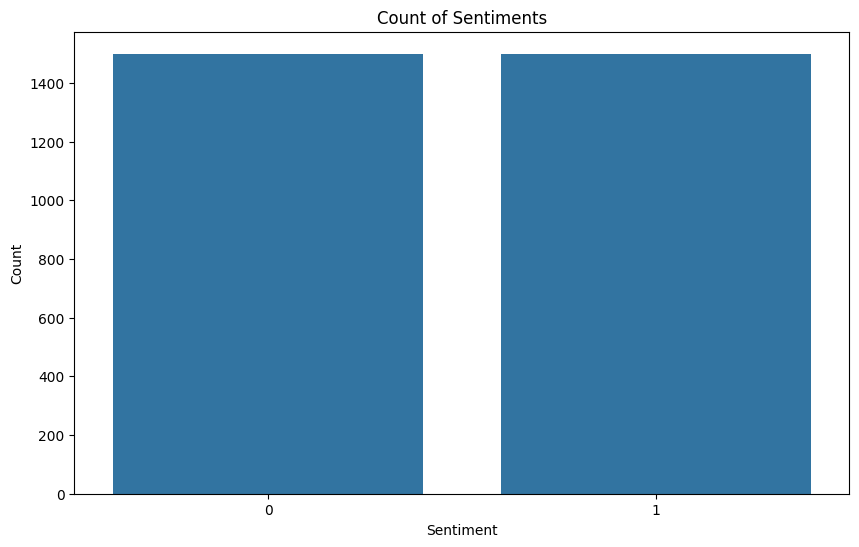

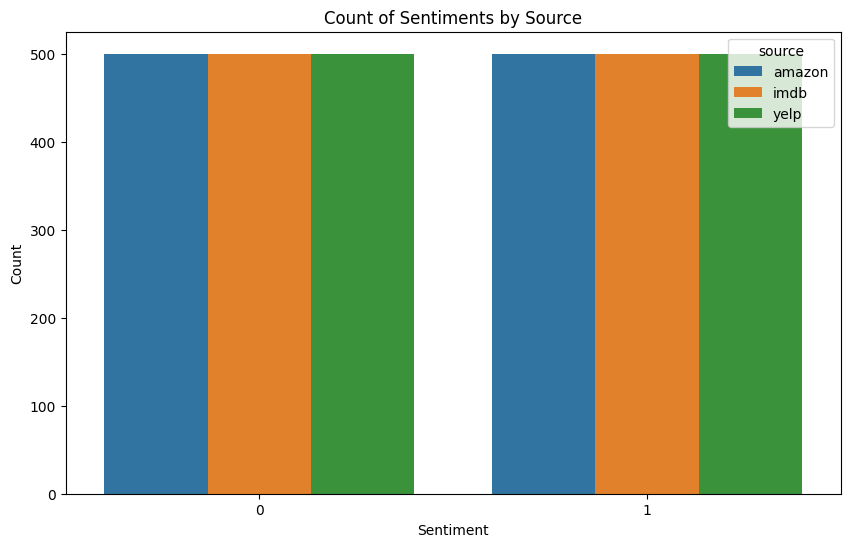

In [7]:
# Check sentiment distribution
sentiment_distribution = df['sentiment'].value_counts(normalize=True)
print("Sentiment distribution:\n", sentiment_distribution)

# Plot sentiment counts
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment')
plt.title('Count of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Plot sentiment counts by source
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment', hue='source')
plt.title('Count of Sentiments by Source')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [8]:
# Convert all letters in the 'reviews' column to lowercase
df['cleaned_review'] = df['reviews'].str.lower()

# Define a dictionary of contractions and their replacements
apos_dict = {
    "'s": " is", "n't": " not", "'m": " am", "'ll": " will",
    "'d": " would", "'ve": " have", "'re": " are", "o'": "o", "'all": " all"
}

# Function to replace contractions
def replace_contractions(text):
    for key, value in apos_dict.items():
        text = text.replace(key, value)
    return text

# Apply contractions replacement
df['cleaned_review'] = df['cleaned_review'].apply(replace_contractions)

# Remove numbers from the cleaned_review text
df['cleaned_review'] = df['cleaned_review'].apply(lambda x: re.sub(r'\d+', '', x))

# Remove special characters and punctuation
df['cleaned_review'] = df['cleaned_review'].str.replace(r"[^\w\s]", ' ', regex=True)

# Replace multiple spaces with a single space
df['cleaned_review'] = df['cleaned_review'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Display cleaned data
print("Cleaned reviews:")
print(df['cleaned_review'].head())

Cleaned reviews:
0    so there is no way for me to plug it in here i...
1                            good case excellent value
2                                great for the jawbone
3    tied to charger for conversations lasting more...
4                                     the mic is great
Name: cleaned_review, dtype: object


In [9]:
# Tokenize the words using regular expressions
df['tokenized_review'] = df['cleaned_review'].apply(lambda x: re.findall(r'\b\w+\b', x))

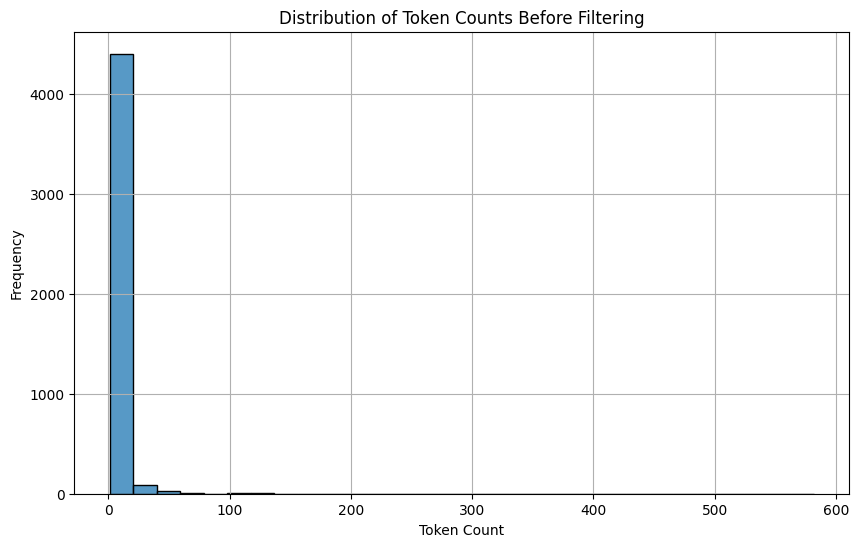

count    4548.000000
mean        4.125550
std        14.004251
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       582.000000
dtype: float64


In [10]:
# Remove stopwords
stop_words = set(stopwords.words('english')) - {'not', 'no'}
df['tokenized_review'] = df['tokenized_review'].apply(lambda x: [word for word in x if word not in stop_words])

# Initialize WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Perform lemmatization
df['tokenized_review'] = df['tokenized_review'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Remove single letter tokens
df['tokenized_review'] = df['tokenized_review'].apply(lambda x: [word for word in x if len(word) > 1])

# Flatten all tokens into a single list
all_tokens = [word for tokens in df['tokenized_review'] for word in tokens]

# Count token occurrences
token_counts = Counter(all_tokens)

# Create a DataFrame for token counts
token_counts_df = pd.DataFrame(token_counts.items(), columns=['token', 'count'])

# Plot the distribution of token counts before filtering
plt.figure(figsize=(10, 6))
sns.histplot(token_counts_df['count'], bins=30)
plt.title('Distribution of Token Counts Before Filtering')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Inspect token counts
token_counts_series = pd.Series(token_counts)
print(token_counts_series.describe())

In [11]:
# Calculate the 80th percentile of token frequencies
percentile_80 = token_counts_series.quantile(0.80)

# Identify tokens that appear more frequently than the 80th percentile count
tokens_above_percentile_80 = {word for word, count in token_counts.items() if count > percentile_80}

# Print the number of tokens above the 80th percentile
print(f"Number of tokens above the 80th percentile: {len(tokens_above_percentile_80)}")

# Print the threshold value for clarity
print(f"Threshold for 80th percentile: {percentile_80}")

Number of tokens above the 80th percentile: 742
Threshold for 80th percentile: 4.0


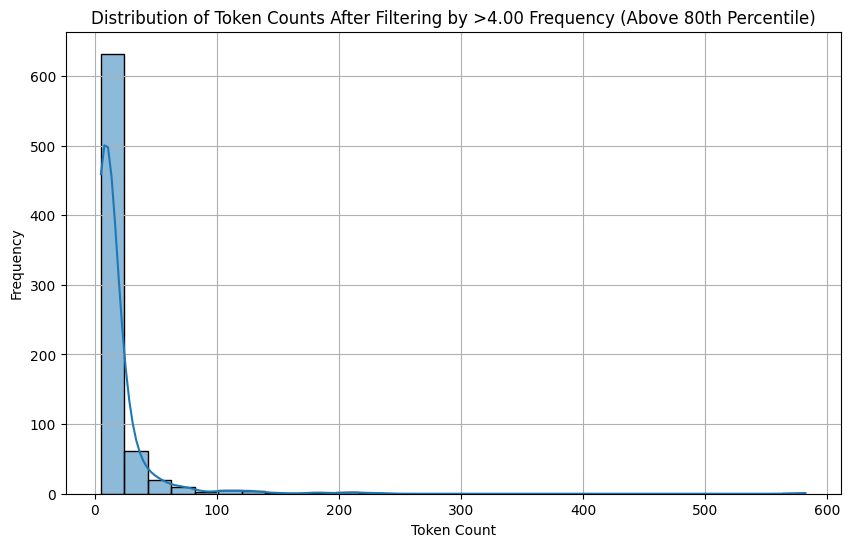

count    742.000000
mean      17.436658
std       31.425308
min        5.000000
25%        6.000000
50%        9.500000
75%       17.000000
max      582.000000
dtype: float64
     token  count
43     not    582
5     good    231
525  movie    212
9    great    210
551   film    187
Threshold for 80th percentile: 4.00


In [12]:
# Filter tokens in the dataset to keep only those in the identified set
df['final_tokens'] = df['tokenized_review'].apply(lambda x: [word for word in x if word in tokens_above_percentile_80])

# Flatten all filtered tokens into a single list for counting
filtered_tokens_threshold = [word for tokens in df['final_tokens'] for word in tokens]

# Count occurrences of each token in the filtered list
filtered_token_counts_threshold = Counter(filtered_tokens_threshold)

# Create a DataFrame from the filtered token counts
filtered_token_counts_df_threshold = pd.DataFrame(filtered_token_counts_threshold.items(), columns=['token', 'count'])

# Plot the distribution of token counts after filtering
plt.figure(figsize=(10, 6))
sns.histplot(filtered_token_counts_df_threshold['count'], bins=30, kde=True)
plt.title(f'Distribution of Token Counts After Filtering by >{percentile_80:.2f} Frequency (Above 80th Percentile)')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Inspect token counts
token_counts_series = pd.Series(filtered_token_counts_threshold)
print(token_counts_series.describe())
print(filtered_token_counts_df_threshold.sort_values(by='count', ascending=False).head())

# Print the threshold value used for clarity
print(f"Threshold for 80th percentile: {percentile_80:.2f}")

In [13]:
# Display the number of unique tokens after filtering
num_unique_tokens = len(set(filtered_tokens_threshold))
print(f"Number of unique tokens after final filtering: {num_unique_tokens}")

Number of unique tokens after final filtering: 742


In [14]:
# Display a random sample from tokens
sample_size = min(20, len(filtered_token_counts_threshold))
sampled_word_counts = random.sample(sorted(filtered_token_counts_threshold.items()), sample_size)
print("Random sample of word counts after final filtering:")
for word, count in sampled_word_counts:
    print(f'Word: {word}, Count: {count}')

Random sample of word counts after final filtering:
Word: recently, Count: 5
Word: whether, Count: 6
Word: damn, Count: 6
Word: range, Count: 6
Word: getting, Count: 12
Word: terrible, Count: 32
Word: junk, Count: 9
Word: rare, Count: 6
Word: night, Count: 18
Word: wear, Count: 9
Word: music, Count: 19
Word: hit, Count: 7
Word: cast, Count: 18
Word: truly, Count: 11
Word: forever, Count: 5
Word: told, Count: 8
Word: entire, Count: 8
Word: connection, Count: 6
Word: something, Count: 10
Word: one, Count: 149


In [15]:
# Display the initial number of rows before removing empty ones
print(f"Initial number of rows: {len(df)}")

# Remove rows with empty token lists
df = df[df['final_tokens'].apply(len) > 0]

# Display the number of rows after removing empty ones
print(f"Number of rows after removing empty token lists: {len(df)}")

# Check if there are any empty lists remaining
empty_rows = df[df['final_tokens'].apply(len) == 0]
print(f"Number of empty rows remaining: {len(empty_rows)}")

Initial number of rows: 3000
Number of rows after removing empty token lists: 2949
Number of empty rows remaining: 0


In [16]:
# Split the data into train, validation, and test sets
labels = df['sentiment']
X_train_val, X_test, y_train_val, y_test = train_test_split(df['final_tokens'], labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

# Display the sizes of the splits
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# Check class distribution in the sets
def class_distribution(labels):
    return pd.Series(labels).value_counts(normalize=True)

print("Training set distribution:\n", class_distribution(y_train))
print("Validation set distribution:\n", class_distribution(y_val))
print("Test set distribution:\n", class_distribution(y_test))

Training set size: 1769
Validation set size: 590
Test set size: 590
Training set distribution:
 sentiment
1    0.500848
0    0.499152
Name: proportion, dtype: float64
Validation set distribution:
 sentiment
1    0.501695
0    0.498305
Name: proportion, dtype: float64
Test set distribution:
 sentiment
1    0.501695
0    0.498305
Name: proportion, dtype: float64


In [17]:
# Calculate sequence lengths before padding - give every vectorized sentence (string) same length
def calculate_sequence_lengths(sequences):
    lengths = [len(seq) for seq in sequences]
    return {
        'max_length': max(lengths),
        'min_length': min(lengths),
        'median_length': np.median(lengths)
    }

# Calculate sequence lengths for each set
train_lengths = calculate_sequence_lengths(X_train)
val_lengths = calculate_sequence_lengths(X_val)
test_lengths = calculate_sequence_lengths(X_test)

# Print sequence lengths for each set
print("Training Set Sequence Lengths:")
print(f"Max Length: {train_lengths['max_length']}")
print(f"Min Length: {train_lengths['min_length']}")
print(f"Median Length: {train_lengths['median_length']}")

print("\nValidation Set Sequence Lengths:")
print(f"Max Length: {val_lengths['max_length']}")
print(f"Min Length: {val_lengths['min_length']}")
print(f"Median Length: {val_lengths['median_length']}")

print("\nTest Set Sequence Lengths:")
print(f"Max Length: {test_lengths['max_length']}")
print(f"Min Length: {test_lengths['min_length']}")
print(f"Median Length: {test_lengths['median_length']}")

Training Set Sequence Lengths:
Max Length: 19
Min Length: 1
Median Length: 4.0

Validation Set Sequence Lengths:
Max Length: 17
Min Length: 1
Median Length: 4.0

Test Set Sequence Lengths:
Max Length: 16
Min Length: 1
Median Length: 4.0


In [18]:
# Tokenizer for the training set
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocabulary_size = len(tokenizer.word_index) + 1
print('Vocabulary size:', vocabulary_size)

Vocabulary size: 740


In [19]:
# Convert text to sequences and pad them - Purpose is to make the input vector as small as possible to improve processing speed since sentiment analysis deals with large volumes of data.
# Post padding means padding is added at end of sequence.
max_length = max(len(x) for x in X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length, padding='post')
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=max_length, padding='post')
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length, padding='post')

# Print one of the train sentences in full with padding to show that it is padded
sample_index = random.randint(0, len(X_train_seq) - 1)  # Get a random index from the training set
sample_sentence = X_train_seq[sample_index]  # Retrieve the sample sentence
original_sentence = X_train.iloc[sample_index]  # Use .iloc for position-based indexing

# Print the original sentence and the padded version
print("Original Sentence:")
print(" ".join(original_sentence))  # Join tokens to form a sentence
print("\nPadded Sentence:")
print(sample_sentence)
print("\nLength of Padded Sentence:")
print(len(sample_sentence))

Original Sentence:
beautiful though

Padded Sentence:
[186 147   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0]

Length of Padded Sentence:
19


In [20]:
# Convert labels to numpy array
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Export DataFrames to CSV
train_df = pd.DataFrame(X_train_seq, columns=[f'Word_{i+1}' for i in range(max_length)])
train_df['label'] = y_train
train_df.to_csv('train_data.csv', index=False)

val_df = pd.DataFrame(X_val_seq, columns=[f'Word_{i+1}' for i in range(max_length)])
val_df['label'] = y_val
val_df.to_csv('val_data.csv', index=False)

test_df = pd.DataFrame(X_test_seq, columns=[f'Word_{i+1}' for i in range(max_length)])
test_df['label'] = y_test
test_df.to_csv('test_data.csv', index=False)

print("DataFrames have been exported to CSV files.")

DataFrames have been exported to CSV files.


In [21]:
# Ensure X_train, X_val, and X_test are NumPy arrays
X_train = np.array(X_train_seq)
X_val = np.array(X_val_seq)
X_test = np.array(X_test_seq)

# Ensure y_train and y_val are also NumPy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (1769, 19)
y_train shape: (1769,)
X_val shape: (590, 19)
y_val shape: (590,)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 740, 32)        │        23,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        53,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,981 (320.24 KB)

 Trainable params: 81,981 (320.24 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4994 - loss: 0.6937 - val_accuracy: 0.4983 - val_loss: 0.6931
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5093 - loss: 0.6935 - val_accuracy: 0.4983 - val_loss: 0.6921
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6675 - loss: 0.5859 - val_accuracy: 0.8186 - val_loss: 0.4189
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8849 - loss: 0.3275 - val_accuracy: 0.8203 - val_loss: 0.4447
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9002 - loss: 0.2796 - val_accuracy: 0.8068 - val_loss: 0.4688
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9092 - loss: 0.2344 - val_accuracy: 0.8220 - val_loss: 0.4369


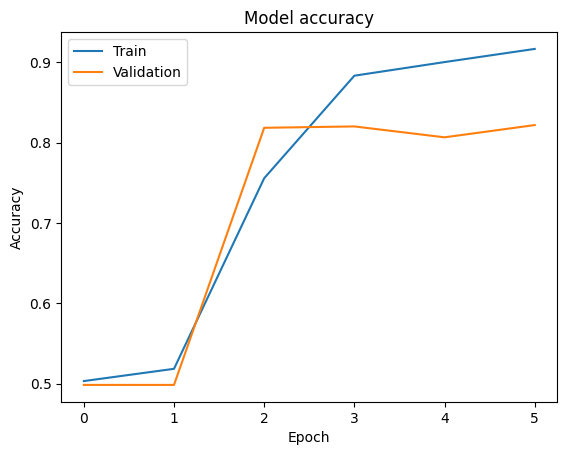

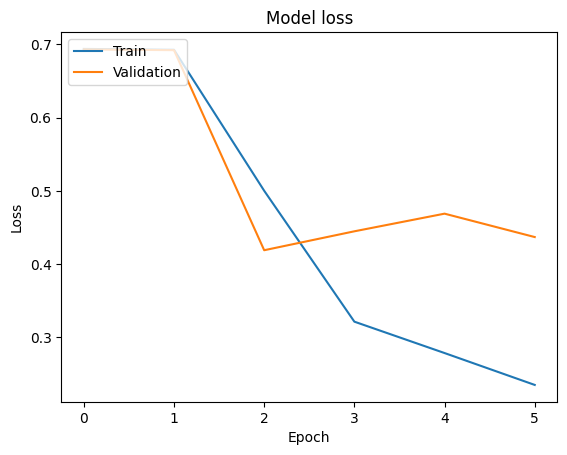

In [22]:
#Set vocabulary size as found above in the training set
vocab_size = vocabulary_size
#Set the input length as 19, the padded length of all inputs
max_length = 19

#Set up the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=32, input_length=max_length)) # input_length is deprecated according to Keras warning

# Add LSTM layer
model.add(LSTM(units=100))

# Add Dropout layer
model.add(Dropout(0.5))

# Add Dense layer with ReLU activation
model.add(Dense(50, activation='relu'))

# Output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

model.build(input_shape=(None, vocab_size))

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
print(model.summary())

# Define early stopping callback - patience prevents overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Model loss is high, which means there is overfitting. Put more layers in your model to prevent overfitting. This will include a dropout layer. Dropouts reduce the over sampling of the data - good for improving model accuracy and lowering loss. Train's model loss dropped, which is good.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 740, 32)        │        23,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200)            │       106,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │        10,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,181 (547.58 KB)

 Trainable params: 140,181 (547.58 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.4954 - loss: 1.5564 - val_accuracy: 0.5017 - val_loss: 0.9200
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5924 - loss: 0.8404 - val_accuracy: 0.7678 - val_loss: 0.6200
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8003 - loss: 0.5302 - val_accuracy: 0.8305 - val_loss: 0.4439
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8831 - loss: 0.3413 - val_accuracy: 0.8288 - val_loss: 0.4362
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9132 - loss: 0.2905 - val_accuracy: 0.8305 - val_loss: 0.5007
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9181 - loss: 0.2364 - val_accuracy: 0.8119 - val_loss: 0.5100
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9319 - loss: 0.2165 - val_accuracy: 0.8034 - val_loss: 0.5400


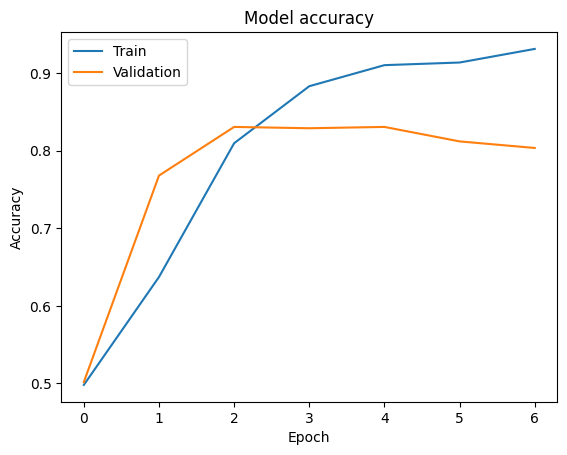

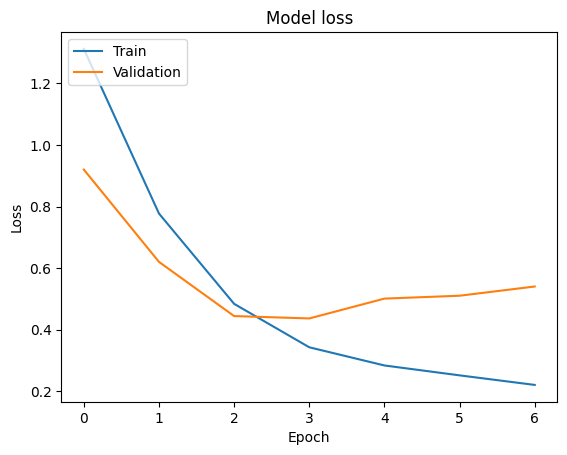

In [23]:
#Set vocabulary size as found above in the training set
vocab_size = vocabulary_size
#Set the input length as 19, the padded length of all inputs
max_length = 19

# Initialize the model
model = Sequential()

# Add an Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=32, input_length=max_length))

# Add a Bidirectional LSTM layer with L2 regularization
model.add(Bidirectional(LSTM(units=100, kernel_regularizer=l2(0.01))))

# Add a Dropout layer
model.add(Dropout(0.5))

# Add Dense layer with ReLU activation
model.add(Dense(50, activation='relu'))

# Output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

model.build(input_shape=(None, vocab_size))

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
print(model.summary())

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 740, 32)        │        23,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 200)            │       106,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │        10,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,181 (547.58 KB)

 Trainable params: 140,181 (547.58 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.4727 - loss: 1.5449 - val_accuracy: 0.5441 - val_loss: 0.9143
Epoch 2/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5822 - loss: 0.8343 - val_accuracy: 0.6458 - val_loss: 0.6515
Epoch 3/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7986 - loss: 0.5201 - val_accuracy: 0.7983 - val_loss: 0.4695
Epoch 4/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8726 - loss: 0.3555 - val_accuracy: 0.8254 - val_loss: 0.4484
Epoch 5/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9107 - loss: 0.2877 - val_accuracy: 0.8136 - val_loss: 0.4774
Epoch 6/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9184 - loss: 0.2477 - val_accuracy: 0.8068 - val_loss: 0.5076
Epoch 7/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9380 - loss: 0.2109 - val_accuracy: 0.7949 - val_loss: 0.5424
Epoch 8/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9387 - loss: 0.2212 - val_accuracy: 0.806

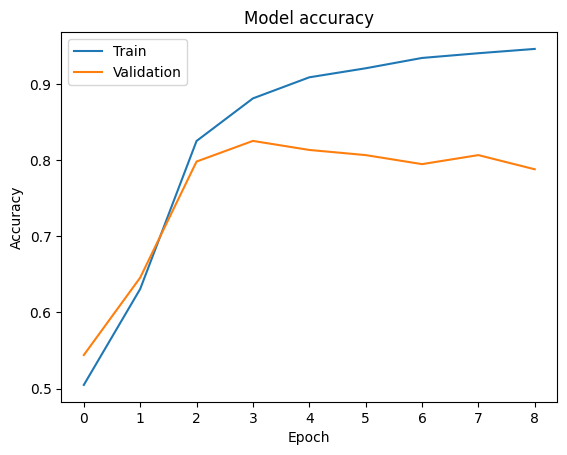

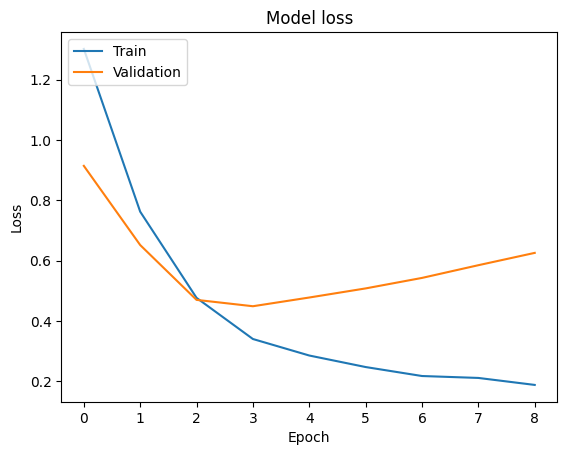

In [24]:
#Set vocabulary size as found above in the training set
vocab_size = vocabulary_size
#Set the input length as 19, the padded length of all inputs
max_length = 19

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=32, input_length=max_length))

# Add a Bidirectional LSTM layer with L2 regularization
model.add(Bidirectional(LSTM(units=100, kernel_regularizer=l2(0.01))))

# increase Dropout layer
model.add(Dropout(0.6))

# Add Dense layer with ReLU activation
model.add(Dense(50, activation='relu'))

# Output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

model.build(input_shape=(None, vocab_size))

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
print(model.summary())

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model - increase epochs to 15.
history = model.fit(
    X_train,
    y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 740, 32)        │        23,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 100)            │        33,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,981 (242.11 KB)

 Trainable params: 61,981 (242.11 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.4992 - loss: 3.6226 - val_accuracy: 0.5508 - val_loss: 2.5659
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5738 - loss: 2.3141 - val_accuracy: 0.6542 - val_loss: 1.6866
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6226 - loss: 1.5435 - val_accuracy: 0.7678 - val_loss: 1.1848
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7147 - loss: 1.0954 - val_accuracy: 0.6373 - val_loss: 0.8743
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7815 - loss: 0.7479 - val_accuracy: 0.8271 - val_loss: 0.5851
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8770 - loss: 0.4958 - val_accuracy: 0.8254 - val_loss: 0.5064
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9154 - loss: 0.3651 - val_accuracy: 0.8288 - val_loss: 0.4792
Epoch 8/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9054 - loss: 0.3093 - val_accuracy: 0.791

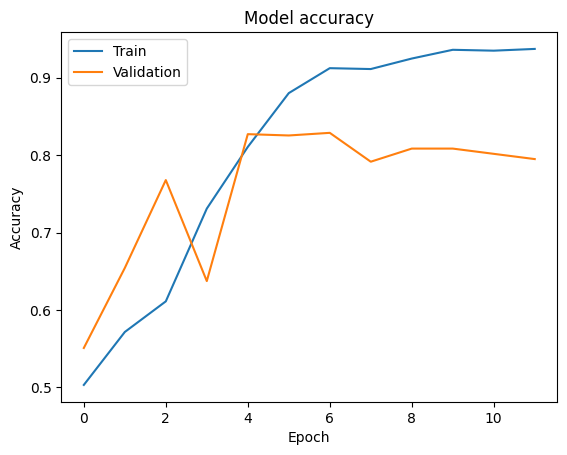

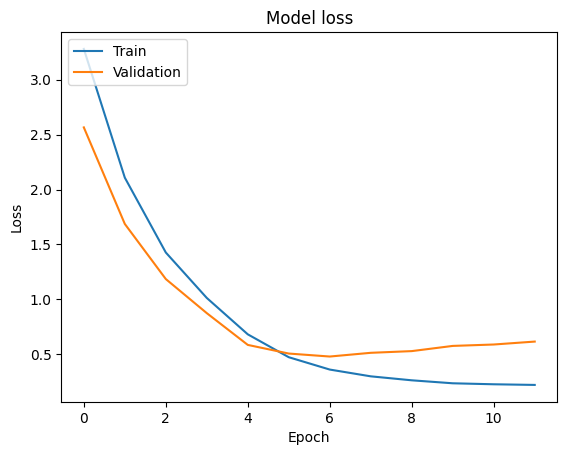

In [25]:
#Set vocabulary size as found above in the training set
vocab_size = vocabulary_size
#Set the input length as 19, the padded length of all inputs
max_length = 19

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=32, input_length=max_length)) # Maps words into 32 dimensional vectors, vectors adjust so that words w/ similar meanings have similar representations
# sequential models require that each layer has weights or connections only to the one layer coming directly after it in the network diagram.

# Add a Bidirectional LSTM layer with L2 regularization - increase L2 rate; BiLSTM process sequences from both directions to capture context
model.add(Bidirectional(LSTM(units=50, kernel_regularizer=l2(0.03))))

# increase Dropout layer
model.add(Dropout(0.7))

# Add Dense layer with ReLU activation; Dense is used because all the nodes in the previous layer connect to all the nodes in the current layer
model.add(Dense(50, activation='relu'))

# Output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

model.build(input_shape=(None, vocab_size))

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
print(model.summary())

# Define early stopping callback - increase patience to 5.
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model - epochs could be set up to 20 or 50 for this type of data if needed. Batch size increased to 62.
history = model.fit(
    X_train,
    y_train,
    epochs=15,
    batch_size=62,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [26]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7927 - loss: 0.5275
Test Loss: 0.5118128061294556
Test Accuracy: 0.803389847278595


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7927 - loss: 0.5275
Test Loss: 0.5118
Test Accuracy: 0.8034
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.79      0.80       294
    Positive       0.79      0.82      0.81       296

    accuracy                           0.80       590
   macro avg       0.80      0.80      0.80       590
weighted avg       0.80      0.80      0.80       590



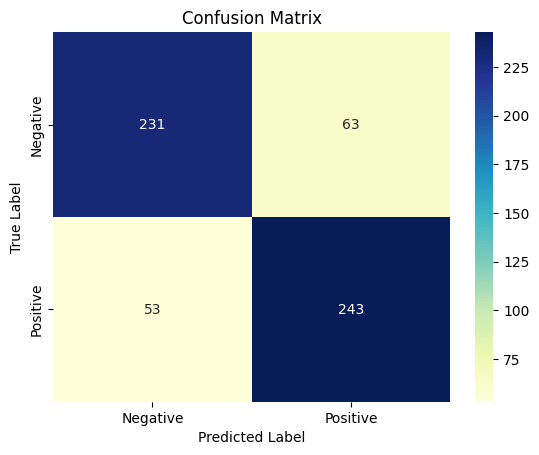

In [27]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict class probabilities and then convert them to binary outcomes
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Calculate evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

# Plotting confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [28]:
# Save model and test predictions
model.save('sentiment_analysis_model.keras')
my_model = load_model('sentiment_analysis_model.keras')
predictions = my_model.predict(X_test)
probability_true = predictions[:, 0]
print(probability_true)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
[0.6811837  0.83966094 0.19740091 0.07099281 0.7842422  0.6711034
 0.4901971  0.25237456 0.08796778 0.98252475 0.9934506  0.97883266
 0.77009624 0.94529307 0.36129272 0.7861681  0.03016557 0.08992652
 0.10739305 0.96468383 0.5905674  0.75895137 0.7117257  0.93108076
 0.6878666  0.08205536 0.2958494  0.05712283 0.27348682 0.9952853
 0.6336348  0.09925561 0.14424439 0.98976403 0.03840682 0.32324398
 0.12088628 0.14814582 0.9732467  0.0190331  0.9947634  0.23576264
 0.6891987  0.04637584 0.13133396 0.9845404  0.1296952  0.9688379
 0.04987659 0.06293157 0.92278135 0.89408284 0.03303015 0.97219926
 0.01906807 0.07368883 0.20220321 0.35748357 0.94824964 0.50426435
 0.3263633  0.09194364 0.03520031 0.03405348 0.08097762 0.3691397
 0.08539778 0.07186443 0.88818    0.9759922  0.44484687 0.08489354
 0.45396158 0.998557   0.05908774 0.02161215 0.19104412 0.17968261
 0.9958922  0.7617254  0.7234188  0.9525458  0.25234908 0.8945533
 0.82985526 0.07512547 0.95